In [2]:
import numpy as np
import matplotlib
import json
import pandas as pd
import os
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from nltk import word_tokenize, pos_tag
from transformers import RobertaTokenizerFast
from pprint import pprint
from wordcloud import WordCloud

In [3]:
bbpe_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def get_num_tokens(text):
    return len(word_tokenize(text))

def get_num_bbpe_tokens(text):
    return len(bbpe_tokenizer(text)["input_ids"])


In [4]:
# Build table for generating dataset statistics
splits = ["train", "valid_seen", "valid_unseen"]
task_fields = ["task_type", "focus_object", "base_object", "dest_object", "scene"]
data_path = "../tars/alfred/data/json_2.1.0"
stats_dict = defaultdict(lambda: [])
action_freqs = defaultdict(lambda: defaultdict(lambda: 0))

for split in splits:
    task_dirs = os.listdir("{}/{}".format(data_path, split))
    for i in tqdm(range(len(task_dirs))):
        task_dir = task_dirs[i]
        task_values = task_dir.split("-")
        for trial_dir in os.listdir("{}/{}/{}".format(data_path, split, task_dir)):
            stats_dict["split"].append(split)
            stats_dict["task_id"].append(trial_dir)

            for j, field in enumerate(task_fields):
                stats_dict[field].append(task_values[j])

            traj_data_file = open("{}/{}/{}/{}/traj_data.json".format(data_path, split, task_dir, trial_dir))
            traj_data = json.load(traj_data_file)
            num_steps_list = []
            num_step_tokens_list = []
            num_task_tokens_list = []

            num_step_bbpe_tokens_list = []
            num_task_bbpe_tokens_list = []

            common_nouns_freq = defaultdict(lambda: 0)
            for directive in traj_data["turk_annotations"]["anns"]:
                num_steps_list.append(len(directive["high_descs"]))
                num_step_tokens_list.append(sum([get_num_tokens(desc) for desc in directive["high_descs"]]))
                num_task_tokens_list.append(get_num_tokens(directive["task_desc"]))
                num_step_bbpe_tokens_list.append(sum([get_num_bbpe_tokens(desc) for desc in directive["high_descs"]]))
                num_task_bbpe_tokens_list.append(get_num_bbpe_tokens(directive["task_desc"]))

                for desc in (directive['high_descs'] + [directive["task_desc"]]):
                    tagged = pos_tag(word_tokenize(desc), tagset='universal')
                    for t in tagged:
                        if t[1] == 'NOUN':
                            common_nouns_freq[t[0]] += 1

            stats_dict['common_nouns_freq'].append(common_nouns_freq)

            stats_dict["steps"].append(np.mean(num_steps_list))
            stats_dict["total_steps_toks"].append(np.mean(num_step_tokens_list))
            stats_dict["total_steps_bbpe_toks"].append(np.mean(num_step_bbpe_tokens_list))
            stats_dict["task_toks"].append(np.mean(num_task_tokens_list))
            stats_dict["task_bbpe_toks"].append(np.mean(num_task_bbpe_tokens_list))
            stats_dict["images"].append(len(traj_data["images"]))
            stats_dict["actions"].append(len(traj_data["plan"]["low_actions"]))        
            stats_dict['total_objects'].append(len(traj_data['scene']['object_poses']))

            nav_count = 0
            interact_count = 0
            mask_cov_per_ac = 0

            for action in traj_data["plan"]["low_actions"]:
                action_freqs[split][action["api_action"]["action"]] += 1
                args = action['discrete_action']['args']
                if "mask" in args:
                    interact_count += 1
                    mask_cov_per_ac += sum([l for _, l in args['mask']])
                else:
                    nav_count += 1

            stats_dict["mask_coverage_per_action"].append(mask_cov_per_ac / (300 * 300 * interact_count))
            stats_dict["nav_actions"].append(nav_count)
            stats_dict["interact_actions"].append(interact_count)


stats_df = pd.DataFrame(stats_dict)
action_df = pd.DataFrame(action_freqs)

100%|██████████| 85/85 [00:05<00:00, 14.95it/s]


In [5]:
# Derive some additional columns
stats_df["toks/step"] = stats_df["total_steps_toks"] / stats_df["steps"]
stats_df["bbpe_toks/step"] = stats_df["total_steps_bbpe_toks"] / stats_df["steps"]
stats_df["actions/step"] = stats_df["actions"] / stats_df["steps"]
stats_df["images/action"] = stats_df["images"] / stats_df["actions"]
stats_df["nav/interact"] = stats_df["nav_actions"] / stats_df["interact_actions"]

stats_df = stats_df.round(2)

In [8]:
pd.set_option('display.max_columns', 100)
stats_df

,split,task_id,task_type,focus_object,base_object,dest_object,scene,common_nouns_freq,steps,total_steps_toks,total_steps_bbpe_toks,task_toks,task_bbpe_toks,images,actions,total_objects,mask_coverage_per_action,nav_actions,interact_actions,toks/step,bbpe_toks/step,actions/step,images/action,nav/interact
0,train,trial_T20190908_225745_649876,pick_cool_then_place_in_recep,Mug,None,CoffeeMachine,11,"{'Turn': 5, 'microwave': 5, 'cup': 10, 'Approa...",6.0,71.67,86.00,9.33,11.67,270,41,49,0.43,31,10,11.94,14.33,6.83,6.59,3.10
1,train,trial_T20190908_021957_189338,pick_cool_then_place_in_recep,Mug,None,CoffeeMachine,11,"{'turn': 3, 'drawer': 1, 'mug': 8, 'fridge': 6...",6.0,62.67,75.33,8.33,10.33,309,56,48,0.36,46,10,10.44,12.56,9.33,5.52,4.60
2,train,trial_T20190908_021916_317022,pick_cool_then_place_in_recep,Mug,None,CoffeeMachine,11,"{'walk': 3, 'front': 2, 'sink': 6, 'mug': 16, ...",6.0,79.00,94.33,11.00,13.67,273,49,43,0.42,41,8,13.17,15.72,8.17,5.57,5.12
3,train,trial_T20190906_233458_108018,pick_clean_then_place_in_recep,DishSponge,None,Cart,430,"{'walk': 2, 'toilet': 6, 'sponge': 16, 'top': ...",6.0,51.00,65.33,9.67,12.00,299,55,26,0.05,49,6,8.50,10.89,9.17,5.44,8.17
4,train,trial_T20190906_233436_645915,pick_clean_then_place_in_recep,DishSponge,None,Cart,430,"{'Move': 2, 'metal': 4, 'rack': 11, 'right': 3...",6.0,63.25,77.75,8.25,10.75,295,53,22,0.05,47,6,10.54,12.96,8.83,5.57,7.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,valid_unseen,trial_T20190909_123918_983775,pick_heat_then_place_in_recep,PotatoSliced,None,Fridge,10,"{'move': 3, 'table': 4, 'knife': 6, 'fridge': ...",12.0,112.67,137.00,10.00,12.00,697,137,51,0.33,118,19,9.39,11.42,11.42,5.09,6.21
7076,valid_unseen,trial_T20190909_124126_852630,pick_heat_then_place_in_recep,PotatoSliced,None,Fridge,10,"{'Turn': 5, 'right': 2, 'counter': 10, 'coffee...",10.0,79.67,101.00,8.67,11.00,392,56,54,0.28,41,15,7.97,10.10,5.60,7.00,2.73
7077,valid_unseen,trial_T20190908_032543_712058,pick_clean_then_place_in_recep,Pan,None,CounterTop,10,"{'Turn': 7, 'stove': 7, 'top': 5, 'side': 1, '...",6.0,82.33,96.67,10.33,12.67,235,41,49,0.09,35,6,13.72,16.11,6.83,5.73,5.83
7078,valid_unseen,trial_T20190908_032518_891433,pick_clean_then_place_in_recep,Pan,None,CounterTop,10,"{'stove': 7, 'Pick': 3, 'pan': 14, 'front': 3,...",6.0,75.33,91.33,10.33,12.33,170,22,49,0.09,16,6,12.56,15.22,3.67,7.73,2.67


In [9]:
action_df

,train,valid_seen,valid_unseen
LookDown,19948,730,776
RotateLeft,27901,1063,1011
MoveAhead,195054,7540,6877
RotateRight,29447,1122,992
OpenObject,6568,257,291
PickupObject,12316,470,459
CloseObject,6637,259,294
PutObject,11569,438,404
LookUp,12566,489,632
ToggleObjectOn,2524,100,132


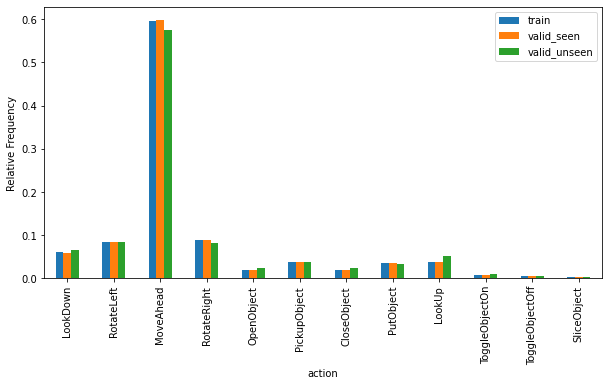

In [10]:
action_plot = action_df.div(action_df.sum(axis=0)).plot.bar(figsize=(10, 5), xlabel="action", ylabel="Relative Frequency")

In [11]:
# Plot frequency of a categorical field. Useful for task_type and maybe objects.
def plot_freq(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    freq_cols = {split:stats_df[stats_df["split"] == split][col].value_counts(normalize=True) for split in splits}
    pd.concat(freq_cols, axis=1).plot.bar(xlabel=col, ylabel="Relative Frequency", **kwargs)

# Plot histogram of a quantitative field. 
def plot_hist(col, **kwargs):
    splits = ["train", "valid_seen", "valid_unseen"]
    axes = stats_df.hist(col, by="split", sharex=True, **kwargs)
    for ax in axes.reshape(-1):
        ax.tick_params(axis="x", which="both", labelbottom=True)
        ax.set_xlabel(col, visible=True)
        ax.set_ylabel("Frequency")

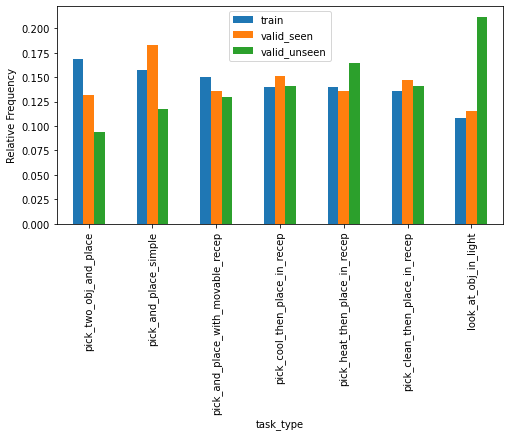

In [12]:
plot_freq("task_type", figsize=(8, 4))

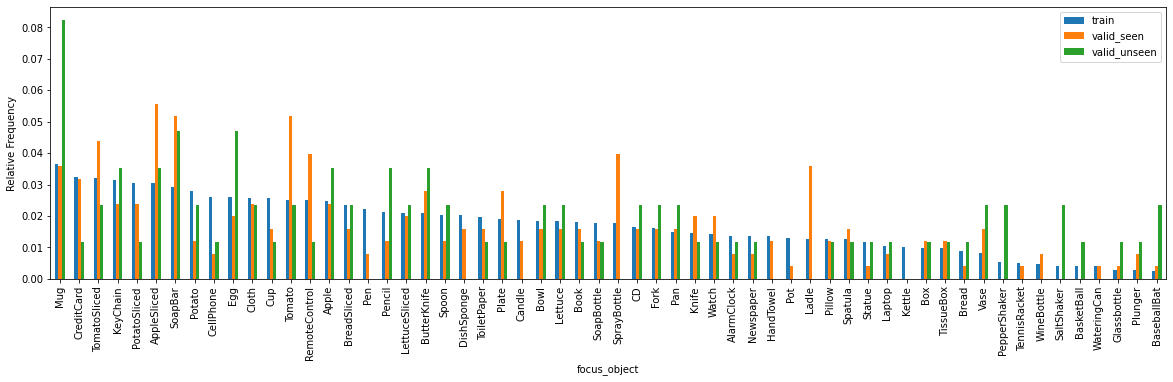

In [13]:
plot_freq("focus_object", figsize=(20, 5))

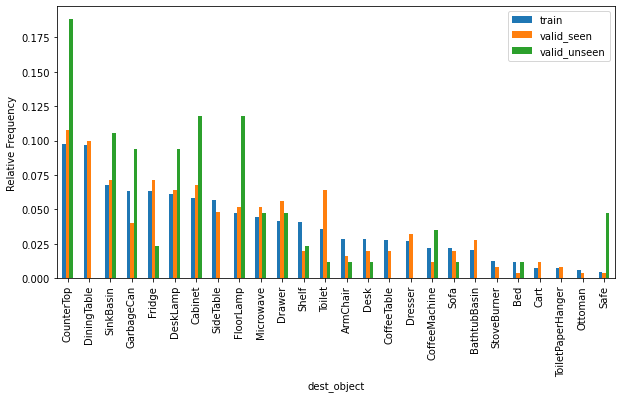

In [14]:
plot_freq("dest_object", figsize=(10, 5))

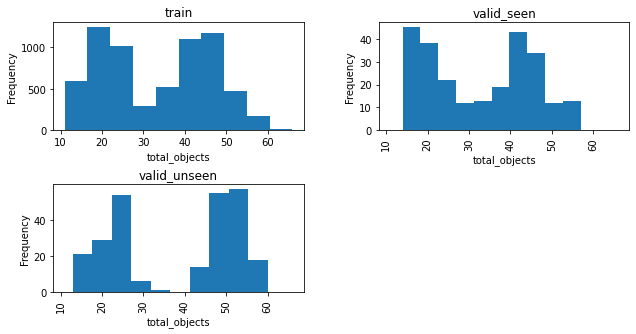

In [15]:
plot_hist("total_objects", figsize=(10, 5))

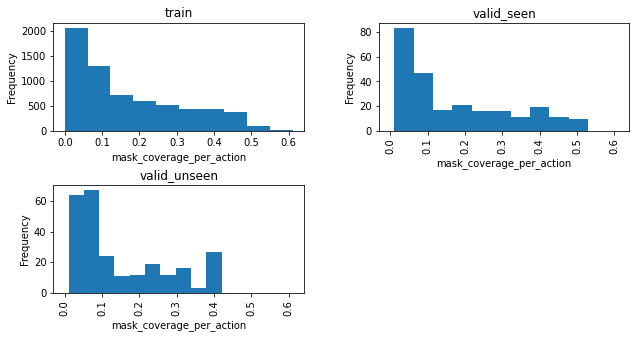

In [16]:
plot_hist("mask_coverage_per_action", figsize=(10, 5))

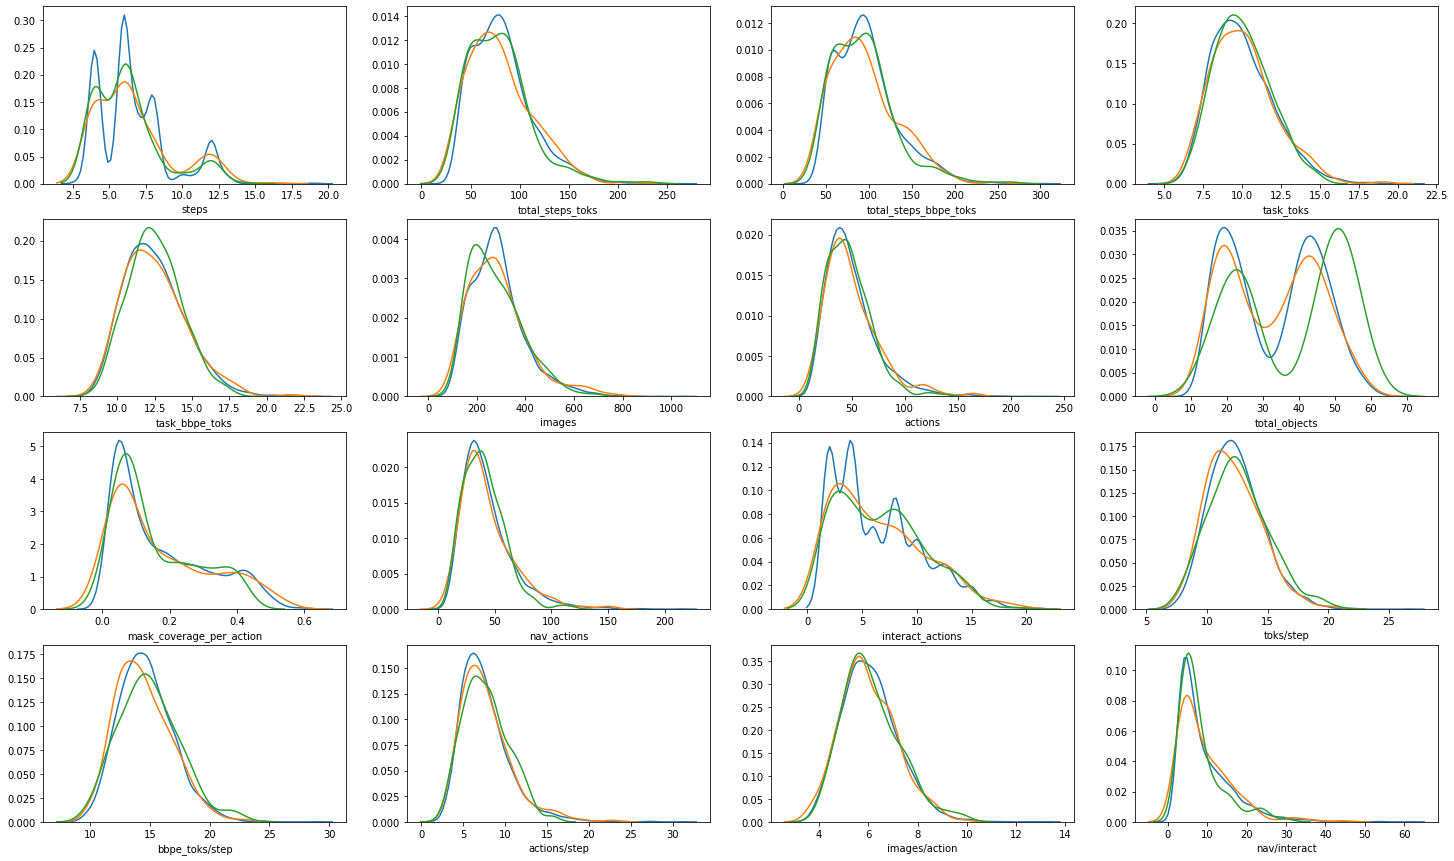

In [17]:
# KDE per split of quantitative fields
# Inspired by https://stackoverflow.com/questions/46045750/python-distplot-with-multiple-distributions

cs = [c for c in stats_df.columns if stats_df[c].dtype != 'O']
splits = stats_df['split'].unique()
df = stats_df[['split'] + cs].melt(['split'], var_name='cols', value_name='vals')
num_cols = 4
num_rows = math.ceil(len(cs) / num_cols)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, 15))

col = 0
for r in range(len(axs)):
    for c in range(len(axs[r])):
        if col >= len(cs):
            break
        for s in splits:
            sns.distplot(stats_df[stats_df['split'] == s][cs[col]], hist=False, rug=False, ax=axs[r][c])
        col += 1


In [18]:
# Mean of quantitative fields
stats_df.groupby('split').mean().round(2)

,steps,total_steps_toks,total_steps_bbpe_toks,task_toks,task_bbpe_toks,images,actions,total_objects,mask_coverage_per_action,nav_actions,interact_actions,toks/step,bbpe_toks/step,actions/step,images/action,nav/interact
split,,,,,,,,,,,,,,,,
train,6.68,81.88,97.16,10.02,12.48,286.75,49.78,33.20,0.17,43.34,6.44,12.39,14.69,7.60,6.08,9.19
valid_seen,6.64,80.20,95.29,10.09,12.52,287.24,50.12,32.84,0.17,43.60,6.52,12.18,14.45,7.72,6.02,9.25
valid_unseen,6.27,78.73,93.16,10.04,12.52,277.72,46.98,38.44,0.15,40.35,6.63,12.63,14.94,7.72,6.12,8.13


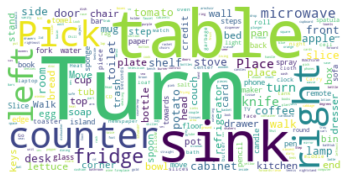

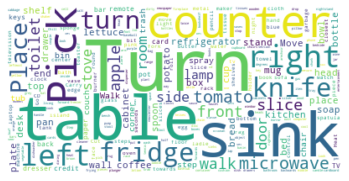

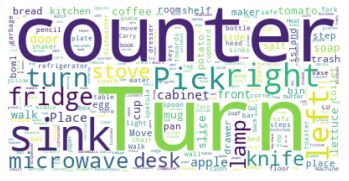

In [19]:
def show_word_cloud(split):
    d = defaultdict(lambda: 0)

    for nouns_dict in stats_df[stats_df['split'] == split]['common_nouns_freq']:
        for k in nouns_dict:
            d[k] += nouns_dict[k]

    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(d)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

show_word_cloud('train')
show_word_cloud('valid_seen')
show_word_cloud('valid_unseen')